In [26]:
# Importing necessary lebraries
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as pl
import joblib
import seaborn as se
from collections import Counter
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [27]:
sys.path.append(os.path.join(os.path.abspath('..')))
# Import modules
from src import data_loader as dl

In [28]:

sys.path.append(os.path.abspath("../"))


from scripts.model import prepare_data, split_data

from scripts.logger import logger 

In [29]:

fraud_df = dl.load_data("processed/processed_fraud_data.csv")


In [30]:
print('No frauds', round(fraud_df['class'].value_counts()[0]/len(fraud_df) * 100,2),
      '% of the dataset')
print('Frauds', round(fraud_df['class'].value_counts()[1]/len(fraud_df) * 100,2),
      '% of the dataset')

No frauds 90.64 % of the dataset
Frauds 9.36 % of the dataset


 dataset - it's  skewed toNo frauds transactions! i want  my model to be vigilant and identify subtle patterns that indicate potential fraud. To achieve this, we must address the class imbalance issue head-on

Feature and Target Separation for Fraud_Data.csv

In [31]:
# fraud_df = fraud_df.sample(frac=1, random_state=42).reset_index(drop=True)
# fraud_df = fraud_df.drop(columns=['Unnamed: 0', 'signup_time', 'purchase_time', 'device_id', 'ip_address'])
# bool_cols = fraud_df.select_dtypes(include=['bool']).columns
# fraud_df[bool_cols] = fraud_df[bool_cols].astype(int)

Feature and Target Separation for Fraud_Data.csv

In [32]:

X_fraud, y_fraud = prepare_data(fraud_df, 'class')

INFO:fraud_detection_logger:Preparing data by separating features and target column: class


2025-07-20 15:40:44,819 - INFO - Preparing data by separating features and target column: class


Train-Test Split for Fraud_Data.csv

In [33]:

X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = split_data(X_fraud, y_fraud)

INFO:fraud_detection_logger:Splitting data into train and test sets


2025-07-20 15:40:44,853 - INFO - Splitting data into train and test sets


In [34]:
print("Fraud Data Shapes:")
print("X_train_fraud:", X_train_fraud.shape)
print("X_test_fraud:", X_test_fraud.shape)
print("y_train_fraud:", y_train_fraud.shape)
print("y_test_fraud:", y_test_fraud.shape)

Fraud Data Shapes:
X_train_fraud: (120889, 21)
X_test_fraud: (30223, 21)
y_train_fraud: (120889,)
y_test_fraud: (30223,)


In [35]:
# Check the distribution of labels in the training and testing sets
train_unique_label, train_counts_label = np.unique(y_train_fraud, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_test_fraud, return_counts=True)


print('Label Distributions: \n')
print('Training set label distribution:', train_counts_label/ len(y_train_fraud))
print('Testing set label distribution:', test_counts_label/ len(y_test_fraud))

Label Distributions: 

Training set label distribution: [0.90651755 0.09348245]
Testing set label distribution: [0.90570096 0.09429904]


In [36]:
non_fraud_sum = fraud_df[fraud_df['class'] == 0].value_counts().sum()
print('non fraud data ', non_fraud_sum)

non fraud data  136961


In [37]:
fraud_sum = fraud_df[fraud_df['class'] == 1].value_counts().sum()
print(' fraud data ', fraud_sum)

 fraud data  14151


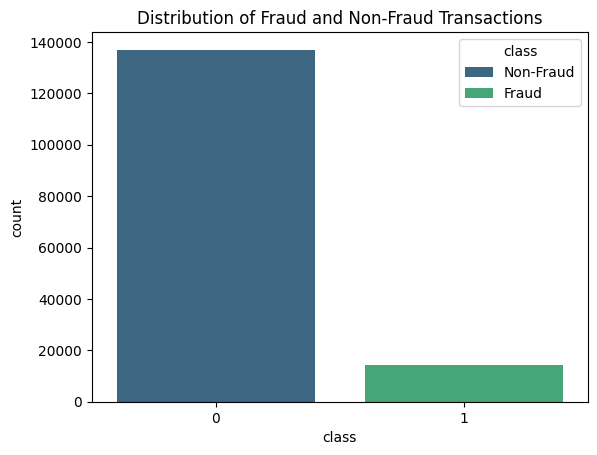

In [38]:
se.countplot(data=fraud_df, x='class', hue='class', palette='viridis')
pl.legend(title='class', labels=['Non-Fraud', 'Fraud'], loc='best')
pl.title('Distribution of Fraud and Non-Fraud Transactions')
pl.show()

In [39]:


# Shuffle dataset
df = fraud_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Get counts of each class
num_fraud = df[df['class'] == 1].shape[0]
num_non_fraud = df[df['class'] == 0].shape[0]

# Determine the smaller class size to balance
min_samples = min(num_fraud, num_non_fraud)

# Undersample both classes to be exactly equal
fraud_sample = df[df['class'] == 1].sample(n=min_samples, random_state=42)
non_fraud_sample = df[df['class'] == 0].sample(n=min_samples, random_state=42)

# Combine balanced data
balanced_df = pd.concat([fraud_sample, non_fraud_sample])

# Shuffle again to mix fraud & non-fraud instances
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Drop unnecessary columns
balanced_df = balanced_df.drop(columns=['Unnamed: 0', 'signup_time', 'purchase_time', 'device_id', 'ip_address'])

# Convert boolean columns to integers
bool_cols = balanced_df.select_dtypes(include=['bool']).columns
balanced_df[bool_cols] = balanced_df[bool_cols].astype(int)

# Verify the class distribution
print(balanced_df['class'].value_counts())

# Display first few rows
balanced_df.head()


class
1    14151
0    14151
Name: count, dtype: int64


,user_id,purchase_value,age,class,hour_of_day,day_of_week,purchase_delay,user_transaction_frequency,device_transaction_frequency,user_transaction_velocity,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M
0,24952,0.494721,-0.712568,1,0.937208,0.492565,-1.577617,0.0,3.177611,4.345476,0,1,0,0,1,0,1
1,124940,-0.214781,-0.248408,0,0.503209,1.489476,0.126940,0.0,-0.261514,-0.230128,0,0,1,0,0,0,0
2,162540,0.658452,-0.596528,0,-0.509456,0.991020,0.936569,0.0,-0.261514,-0.230129,0,1,0,1,0,0,0
3,59847,0.003527,-1.640890,0,1.371208,-0.005891,0.179193,0.0,-0.261514,-0.230128,0,1,0,0,0,0,1
4,360735,-0.978861,-0.364448,1,-0.220124,-0.504347,-1.577617,0.0,5.470361,4.345476,0,0,0,0,0,0,0


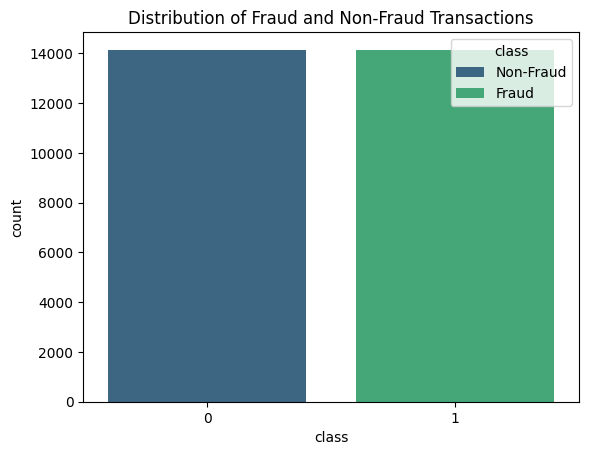

In [40]:
se.countplot(data=balanced_df, x='class', hue='class', palette='viridis')
pl.legend(title='class', labels=['Non-Fraud', 'Fraud'], loc='best')
pl.title('Distribution of Fraud and Non-Fraud Transactions')
pl.show()

In [41]:
X_fraud, y_fraud = prepare_data(balanced_df, 'class')

INFO:fraud_detection_logger:Preparing data by separating features and target column: class


2025-07-20 15:40:46,975 - INFO - Preparing data by separating features and target column: class


In [42]:
X_train = X_train_fraud.values
X_test = X_test_fraud.values
y_train = y_train_fraud.values
X_test = X_test_fraud.values
y_test = y_test_fraud.values

In [43]:
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = split_data(X_fraud, y_fraud)


INFO:fraud_detection_logger:Splitting data into train and test sets


2025-07-20 15:40:47,259 - INFO - Splitting data into train and test sets


In [44]:
X_train_fraud = X_train_fraud.astype('float64')
X_test_fraud = X_test_fraud.astype('float64')


In [45]:
# Train and evaluate Logistic Regression model for Fraud_Data.csv
with mlflow.start_run(run_name="Logistic Regression - Fraud Data"):
    logistic_model = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced')  # Increased max_iter & balanced class weights
    
    # Ensure feature data is in float64 to avoid MLflow warnings
    X_train_fraud = X_train_fraud.astype('float64')
    X_test_fraud = X_test_fraud.astype('float64')

    logistic_model.fit(X_train_fraud, y_train_fraud)
    y_pred_fraud = logistic_model.predict(X_test_fraud)

    # Generate classification report
    report_fraud = classification_report(y_test_fraud, y_pred_fraud, output_dict=True)
    accuracy_fraud = report_fraud['accuracy']

    # Log parameters, metrics, and model
    mlflow.log_param("model", "Logistic Regression")
    mlflow.log_metric("accuracy", accuracy_fraud)
    mlflow.sklearn.log_model(logistic_model, "logistic_model_fraud", input_example=X_test_fraud[:5])

    # Print classification report
    print("Logistic Regression - Fraud Data:\n", classification_report(y_test_fraud, y_pred_fraud))

2025/07/20 15:40:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\HP\Desktop\10 acd\week 8 -9\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Logistic Regression - Fraud Data:
               precision    recall  f1-score   support

           0       0.72      0.98      0.83      2853
           1       0.96      0.62      0.76      2808

    accuracy                           0.80      5661
   macro avg       0.84      0.80      0.79      5661
weighted avg       0.84      0.80      0.79      5661



In [46]:
# Train and evaluate Decision Tree model for Fraud_Data.csv
with mlflow.start_run(run_name="Decision Tree - Fraud Data"):
    decision_tree_model = DecisionTreeClassifier()
    
    # Ensure feature data is in float64 to avoid MLflow warnings
    X_train_fraud = X_train_fraud.astype('float64')
    X_test_fraud = X_test_fraud.astype('float64')
    
    # Convert integer columns in X_test_fraud to float64 to avoid schema enforcement warnings
    X_test_fraud = X_test_fraud.astype('float64')
    
    decision_tree_model.fit(X_train_fraud, y_train_fraud)
    y_pred_fraud = decision_tree_model.predict(X_test_fraud)

    # Generate classification report
    report_fraud = classification_report(y_test_fraud, y_pred_fraud, output_dict=True)
    accuracy_fraud = report_fraud['accuracy']

    # Log parameters, metrics, and model
    mlflow.log_param("model", "Decision Tree")
    mlflow.log_metric("accuracy", accuracy_fraud)
    mlflow.sklearn.log_model(decision_tree_model, "decision_tree_model_fraud", input_example=X_test_fraud[:5])

    # Print classification report
    print("Decision Tree - Fraud Data:\n", classification_report(y_test_fraud, y_pred_fraud))

2025/07/20 15:40:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\HP\Desktop\10 acd\week 8 -9\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Decision Tree - Fraud Data:
               precision    recall  f1-score   support

           0       0.73      0.70      0.71      2853
           1       0.71      0.73      0.72      2808

    accuracy                           0.72      5661
   macro avg       0.72      0.72      0.72      5661
weighted avg       0.72      0.72      0.72      5661



In [47]:
# Train and evaluate Random Forest model
with mlflow.start_run(run_name="Random Forest - Fraud Data"):
    random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Ensure feature data is in float64 to avoid MLflow warnings
    X_train = X_train.astype('float64')
    X_test = X_test.astype('float64')

    random_forest_model.fit(X_train, y_train)  # Train the model
    y_pred_fraud = random_forest_model.predict(X_test)  # Predict on test data

    # Generate classification report
    report_fraud = classification_report(y_test, y_pred_fraud, output_dict=True)
    accuracy_fraud = report_fraud['accuracy']

    # Log parameters, metrics, and model
    mlflow.log_param("model", "Random Forest")
    mlflow.log_metric("accuracy", accuracy_fraud)
    mlflow.sklearn.log_model(random_forest_model, "random_forest_model_fraud", input_example=X_test[:5])

    # Print classification report
    print("Random Forest - Fraud Data:\n", classification_report(y_test, y_pred_fraud))


ValueError: could not convert string to float: '2015-01-05 06:37:15'

In [48]:
# Train and evaluate Gradient Boosting model for Fraud_Data.csv
with mlflow.start_run(run_name="Gradient Boosting - Fraud Data"):
    gradient_boosting_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    
    # Ensure feature data is in float64 to avoid MLflow warnings
    X_train_fraud = X_train_fraud.astype('float64')
    X_test_fraud = X_test_fraud.astype('float64')

    gradient_boosting_model.fit(X_train_fraud, y_train_fraud)
    y_pred_fraud = gradient_boosting_model.predict(X_test_fraud)

    # Generate classification report
    report_fraud = classification_report(y_test_fraud, y_pred_fraud, output_dict=True)
    accuracy_fraud = report_fraud['accuracy']

    # Log parameters, metrics, and model
    mlflow.log_param("model", "Gradient Boosting")
    mlflow.log_metric("accuracy", accuracy_fraud)
    mlflow.sklearn.log_model(gradient_boosting_model, "gradient_boosting_model_fraud", input_example=X_test_fraud[:5])

    # Print classification report
    print("Gradient Boosting - Fraud Data:\n", classification_report(y_test_fraud, y_pred_fraud))


2025/07/20 15:41:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\HP\Desktop\10 acd\week 8 -9\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Gradient Boosting - Fraud Data:
               precision    recall  f1-score   support

           0       0.77      0.94      0.85      2853
           1       0.93      0.71      0.80      2808

    accuracy                           0.83      5661
   macro avg       0.85      0.83      0.83      5661
weighted avg       0.85      0.83      0.83      5661



In [49]:
# Train and evaluate MLP model for Fraud_Data.csv
with mlflow.start_run(run_name="MLP - Fraud Data"):
    mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=0.0001, solver='adam', random_state=42)
    
    # Ensure feature data is in float64 to avoid MLflow warnings
    X_train_fraud = X_train_fraud.astype('float64')
    X_test_fraud = X_test_fraud.astype('float64')

    mlp_model.fit(X_train_fraud, y_train_fraud)
    y_pred_fraud = mlp_model.predict(X_test_fraud)

    # Generate classification report
    report_fraud = classification_report(y_test_fraud, y_pred_fraud, output_dict=True)
    accuracy_fraud = report_fraud['accuracy']

    # Log parameters, metrics, and model
    mlflow.log_param("model", "MLP")
    mlflow.log_metric("accuracy", accuracy_fraud)
    mlflow.sklearn.log_model(mlp_model, "mlp_model_fraud", input_example=X_test_fraud[:5])

    # Print classification report
    print("MLP - Fraud Data:\n", classification_report(y_test_fraud, y_pred_fraud))

2025/07/20 15:41:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\HP\Desktop\10 acd\week 8 -9\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


MLP - Fraud Data:
               precision    recall  f1-score   support

           0       0.78      0.04      0.08      2853
           1       0.50      0.99      0.67      2808

    accuracy                           0.51      5661
   macro avg       0.64      0.51      0.37      5661
weighted avg       0.64      0.51      0.37      5661



In [50]:
fraud_df = fraud_df.sample(frac=1, random_state=42).reset_index(drop=True)
fraud_df = fraud_df.drop(columns=['Unnamed: 0', 'signup_time', 'purchase_time', 'device_id', 'ip_address'])
bool_cols = fraud_df.select_dtypes(include=['bool']).columns
fraud_df[bool_cols] = fraud_df[bool_cols].astype(int)

In [51]:
# Split data into features (X) and target (y)
X_u_o = fraud_df.drop(columns=['class'])
y_u_o = fraud_df['class']

# Split the original data into training and test sets
X_train, X_test, y_train, y_test = split_data(X_u_o, y_u_o, test_size=0.2, random_state=42)

# Convert Date-Time Column to Numerical Features if necessary





# Convert the training and test sets to 'float64' data type
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

INFO:fraud_detection_logger:Splitting data into train and test sets


2025-07-20 15:41:42,288 - INFO - Splitting data into train and test sets


In [52]:
# Define the resampling strategies
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.2)

# Split data into features (X) and target (y)
# Split data into features (X) and target (y)
X_u_o = fraud_df.drop(columns=['class'])
y_u_o = fraud_df['class']

# Apply under-sampling first
X_under, y_under = under.fit_resample(X_u_o, y_u_o)

# Apply over-sampling on the under-sampled data
X_resampled, y_resampled = over.fit_resample(X_under, y_under)

# Now you can use the resampled data for further processing
print(Counter(y_resampled))

Counter({0: 70755, 1: 35377})


In [53]:
X_train_fraud = X_train_fraud.astype('float64')
X_test_fraud = X_test_fraud.astype('float64')


In [54]:
# Train and evaluate Logistic Regression model
with mlflow.start_run(run_name="Logistic Regression - Fraud Data"):
    logistic_model = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced')

    logistic_model.fit(X_resampled, y_resampled)  # Train on resampled training data

    y_pred_fraud = logistic_model.predict(X_test)  # Predict on original test data

    # Generate classification report
    report_fraud = classification_report(y_test, y_pred_fraud, output_dict=True)
    accuracy_fraud = report_fraud['accuracy']

    # Log parameters, metrics, and model
    mlflow.log_param("model", "Logistic Regression")
    mlflow.log_metric("accuracy", accuracy_fraud)
    mlflow.sklearn.log_model(logistic_model, "logistic_model_fraud", input_example=X_test[:5])

    # Print classification report
    print("Logistic Regression - Fraud Data:\n", classification_report(y_test, y_pred_fraud))

2025/07/20 15:41:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\HP\Desktop\10 acd\week 8 -9\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Logistic Regression - Fraud Data:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     27382
           1       0.77      0.59      0.67      2841

    accuracy                           0.95     30223
   macro avg       0.87      0.78      0.82     30223
weighted avg       0.94      0.95      0.94     30223



In [55]:
# Train and evaluate Decision Tree model
with mlflow.start_run(run_name="Decision Tree - Fraud Data"):
    decision_tree_model = DecisionTreeClassifier()

    # Ensure feature data is in float64 to avoid MLflow warnings
    X_train = X_train.astype('float64')
    X_test = X_test.astype('float64')

    # Convert integer columns in X_test to float64 to avoid schema enforcement warnings
    X_test = X_test.astype('float64')

    decision_tree_model.fit(X_train, y_train)  # Train the model
    y_pred_fraud = decision_tree_model.predict(X_test)  # Predict on test data

    # Generate classification report
    report_fraud = classification_report(y_test, y_pred_fraud, output_dict=True)
    accuracy_fraud = report_fraud['accuracy']

    # Log parameters, metrics, and model
    mlflow.log_param("model", "Decision Tree")
    mlflow.log_metric("accuracy", accuracy_fraud)
    mlflow.sklearn.log_model(decision_tree_model, "decision_tree_model_fraud", input_example=X_test[:5])

    # Print classification report
    print("Decision Tree - Fraud Data:\n", classification_report(y_test, y_pred_fraud))


2025/07/20 15:41:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\HP\Desktop\10 acd\week 8 -9\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Decision Tree - Fraud Data:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95     27382
           1       0.55      0.60      0.57      2841

    accuracy                           0.92     30223
   macro avg       0.75      0.77      0.76     30223
weighted avg       0.92      0.92      0.92     30223



In [56]:
# Train and evaluate Random Forest model for Fraud_Data.csv
with mlflow.start_run(run_name="Random Forest - Fraud Data"):
    random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Ensure feature data is in float64 to avoid MLflow warnings
    X_train_fraud = X_train_fraud.astype('float64')
    X_test_fraud = X_test_fraud.astype('float64')

    random_forest_model.fit(X_train_fraud, y_train_fraud)
    y_pred_fraud = random_forest_model.predict(X_test_fraud)

    # Generate classification report
    report_fraud = classification_report(y_test_fraud, y_pred_fraud, output_dict=True)
    accuracy_fraud = report_fraud['accuracy']

    # Log parameters, metrics, and model
    mlflow.log_param("model", "Random Forest")
    mlflow.log_metric("accuracy", accuracy_fraud)
    mlflow.sklearn.log_model(random_forest_model, "random_forest_model_fraud", input_example=X_test_fraud[:5])

    # Print classification report
    print("Random Forest - Fraud Data:\n", classification_report(y_test_fraud, y_pred_fraud))


2025/07/20 15:42:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\HP\Desktop\10 acd\week 8 -9\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Random Forest - Fraud Data:
               precision    recall  f1-score   support

           0       0.77      0.94      0.85      2853
           1       0.92      0.71      0.80      2808

    accuracy                           0.83      5661
   macro avg       0.85      0.83      0.82      5661
weighted avg       0.85      0.83      0.82      5661



In [57]:
# Train and evaluate Gradient Boosting model
with mlflow.start_run(run_name="Gradient Boosting - Fraud Data"):
    gradient_boosting_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

    # Ensure feature data is in float64 to avoid MLflow warnings
    X_train = X_train.astype('float64')
    X_test = X_test.astype('float64')

    gradient_boosting_model.fit(X_train, y_train)  # Train the model
    y_pred_fraud = gradient_boosting_model.predict(X_test)  # Predict on test data

    # Generate classification report
    report_fraud = classification_report(y_test, y_pred_fraud, output_dict=True)
    accuracy_fraud = report_fraud['accuracy']

    # Log parameters, metrics, and model
    mlflow.log_param("model", "Gradient Boosting")
    mlflow.log_metric("accuracy", accuracy_fraud)
    mlflow.sklearn.log_model(gradient_boosting_model, "gradient_boosting_model_fraud", input_example=X_test[:5])

    # Print classification report
    print("Gradient Boosting - Fraud Data:\n", classification_report(y_test, y_pred_fraud))


2025/07/20 15:42:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\HP\Desktop\10 acd\week 8 -9\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Gradient Boosting - Fraud Data:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98     27382
           1       1.00      0.54      0.70      2841

    accuracy                           0.96     30223
   macro avg       0.98      0.77      0.84     30223
weighted avg       0.96      0.96      0.95     30223



In [58]:
# Train and evaluate MLP model
with mlflow.start_run(run_name="MLP - Fraud Data"):
    mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=0.0001, solver='adam', random_state=42)

    # Ensure feature data is in float64 to avoid MLflow warnings
    X_train = X_train.astype('float64')
    X_test = X_test.astype('float64')

    mlp_model.fit(X_train, y_train)  # Train the model
    y_pred_fraud = mlp_model.predict(X_test)  # Predict on test data

    # Generate classification report
    report_fraud = classification_report(y_test, y_pred_fraud, output_dict=True)
    accuracy_fraud = report_fraud['accuracy']

    # Log parameters, metrics, and model
    mlflow.log_param("model", "MLP")
    mlflow.log_metric("accuracy", accuracy_fraud)
    mlflow.sklearn.log_model(mlp_model, "mlp_model_fraud", input_example=X_test[:5])

    # Print classification report
    print("MLP - Fraud Data:\n", classification_report(y_test, y_pred_fraud))


2025/07/20 15:43:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\HP\Desktop\10 acd\week 8 -9\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


MLP - Fraud Data:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     27382
           1       0.97      0.45      0.62      2841

    accuracy                           0.95     30223
   macro avg       0.96      0.73      0.80     30223
weighted avg       0.95      0.95      0.94     30223



### Summary
Logistic Regression: Performs better after SMOTE in overall accuracy and Class 0 metrics, but with a slight drop in Class 1 recall and F1-score.

Decision Tree: Performs better after SMOTE in overall accuracy and Class 0 metrics, but with a drop in Class 1 metrics.

Random Forest: Performs better before SMOTE with higher overall accuracy and balanced precision and recall for both classes. After SMOTE, the Class 1 metrics improve but overall accuracy drops.

Gradient Boosting: Performs better before SMOTE with higher recall for Class 1. After SMOTE, overall accuracy improves but recall for Class 1 drops significantly.

MLP: Performs better after SMOTE in overall accuracy and Class 0 metrics, with consistent F1-score for Class 1.

Logistic Regression and Random Forest models showed significant improvements in identifying fraudulent transactions after applying SMOTE.

Decision Tree and Gradient Boosting models showed a decrease in recall for Class 1 after applying SMOTE.

MLP model's recall for Class 1 remained consistent before and after applying SMOTE.

Identifying fraudulent transactions (Class 1) is my primary goal,am focusing on  Logistic Regression and  Random Forest models after applying SMOTE, as they have shown improvement in recall for Class 1. This means they are better at correctly identifying fraudulent transactions after the resampling process.

Random Forest is the best model after applying SMOTE due to its balanced and high performance in identifying fraudulent transactions, making it well-suited for fraud detection tasks. If you want to further optimize the model, you can experiment with hyperparameter tuning or feature engineering to achieve even better results.

In [59]:


# Define the path to save the model
model_folder = "models"
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

model_path = os.path.join(model_folder, "random_forest_model_fraud.pkl")

# Save the model
joblib.dump(random_forest_model, model_path)

print(f"Model saved at: {model_path}")


Model saved at: models\random_forest_model_fraud.pkl
